## Computational Intellegence ##
### 2024 Fall ###

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
#from anfis import ANFIS
#from membership import BelMembFunc, makeMF

## Load Dataset ##

In [2]:
data = pd.read_csv('ev_charging_patterns.csv')
data.head()

User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346                   0.591363           36.389181   
1              12.339275                   3.133652           30.677735   
2              19.128876                   2.452653           27.513593   
3              79.457824                   1.266431           32.882870   
4              19.629104                   2.019765           10.215712   

   Charging Cost (USD) Time of Day Day of Week  State of Charge (Start %)  \
0            13.087717     Evening     Tuesday                  29.371576   
1            21.128448     Morning      Monday                  10.115778   
2            35.667270     Morning    Thursday                   6.854604   
3            13.036239     Evening    Saturday                  83.120003   
4            10.161471     Morning    Saturday                  54.258950   

   State of Charge (End %)  Distance Driven (since last charge) (km)  \
0                86.119962                                293.602111   
1                84.664344                                112.112804   
2                69.917615                                 71.799253   
3                99.624328                                199.577785   
4                63.743786                                203.661847   

   Temperature (°C)  Vehicle Age (years)     Charger Type  \
0         27.947953                  2.0  DC Fast Charger   
1         14.311026                  3.0          Level 1   
2         21.002002                  2.0          Level 2   
3         38.316313                  1.0          Level 1   
4         -7.834199                  1.0          Level 1   

                User Type  
0                Commuter  
1           Casual Driver  
2                Commuter  
3  Long-Distance Traveler  
4  Long-Distance Traveler

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

Battery Capacity (kWh)  Energy Consumed (kWh)  \
count             1320.000000            1254.000000   
mean                74.534692              42.642894   
std                 20.626914              22.411705   
min                  1.532807               0.045772   
25%                 62.000000              23.881193   
50%                 75.000000              42.691405   
75%                 85.000000              61.206218   
max                193.003074             152.238758   

       Charging Duration (hours)  Charging Rate (kW)  Charging Cost (USD)  \
count                1320.000000         1254.000000          1320.000000   
mean                    2.269377           25.963003            22.551352   
std                     1.061037           14.011326            10.751494   
min                     0.095314            1.472549             0.234317   
25%                     1.397623           13.856583            13.368141   
50%                     2.258136           25.603799            22.076360   
75%                     3.112806           37.502998            31.646044   
max                     7.635145           97.342255            69.407743   

       State of Charge (Start %)  State of Charge (End %)  \
count                1320.000000              1320.000000   
mean                   49.130012                75.141590   
std                    24.074134                17.080580   
min                     2.325959                 7.604224   
25%                    27.786903                62.053266   
50%                    48.241771                75.682496   
75%                    69.277921                88.201370   
max                   152.489761               177.708666   

       Distance Driven (since last charge) (km)  Temperature (°C)  \
count                               1254.000000       1320.000000   
mean                                 153.596788         15.263591   
std                                   86.004987         14.831216   
min                                    0.862361        -10.724770   
25%                                   79.445335          2.800664   
50%                                  152.259867         14.630846   
75%                                  226.073284         27.981810   
max                                  398.364775         73.169588   

       Vehicle Age (years)  
count          1320.000000  
mean              3.612843  
std               2.309824  
min               0.000000  
25%               2.000000  
50%               4.000000  
75%               6.000000  
max              11.688592

### Handling missing values ###

In [8]:
# Check for missing values in the dataset
print('Missing values before imputation:\n', data.isnull().sum())

Missing values before imputation:
 User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64


In [10]:
# Impute missing values using the mean for continuous numeric columns
missing_data = ['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']
imputer = SimpleImputer(strategy='mean')
data[missing_data] = imputer.fit_transform(data[missing_data])

# Check again to ensure all missing values have been handled
print('\nMissing values after imputation:\n', data.isnull().sum())

# save the cleaned dataset
data.to_csv('cleaned_ev_charging_patterns.csv')

data = pd.read_csv('cleaned_ev_charging_patterns.csv')


Missing values after imputation:
 User ID                                     0
Vehicle Model                               0
Battery Capacity (kWh)                      0
Charging Station ID                         0
Charging Station Location                   0
Charging Start Time                         0
Charging End Time                           0
Energy Consumed (kWh)                       0
Charging Duration (hours)                   0
Charging Rate (kW)                          0
Charging Cost (USD)                         0
Time of Day                                 0
Day of Week                                 0
State of Charge (Start %)                   0
State of Charge (End %)                     0
Distance Driven (since last charge) (km)    0
Temperature (°C)                            0
Vehicle Age (years)                         0
Charger Type                                0
User Type                                   0
dtype: int64


#### **Data correlation for the dataset**

In [ ]:
# Plot the correltion heatmap
# Select only numeric columns for correlation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatlmap of Features")
plt.show()

### Feature Engineering ###

In [13]:
# Convert time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Feature 1: Extract the time features
data['Hour of Day'] = data['Charging Start Time'].dt.hour
data['Start Day'] = data['Charging Start Time'].dt.day
data['Start Month'] = data['Charging Start Time'].dt.month
data['Start Weekday'] = data['Charging Start Time'].dt.weekday  # 0=Monday, 6=Sunday
data['Is Weekend'] = data['Start Weekday'] >= 5

# Feature 2: Create 'Charging Efficiency (kWh/hour)' as Energy Consumed divided by Charging Duration
data['Charging Efficiency (kWh/hour)'] = data['Energy Consumed (kWh)'] / data['Charging Duration (hours)']

# Feature 3: Create 'State of Charge Delta (%)' as the difference between End and Start percentages
data['State of Charge Delta (%)'] = data['State of Charge (End %)'] - data['State of Charge (Start %)']

# Create a new feature to flag if charging occurred between 80% and 100%
data['Charging 80-100%'] = ((data['State of Charge (Start %)'] < 100) & (data['State of Charge (End %)'] > 80)).astype(int)

# Create a new feature to calculate cost per kWh
data['Cost per kWh'] = data['Charging Cost (USD)'] / data['Energy Consumed (kWh)']

data.head()

Unnamed: 0 User ID Vehicle Model  Battery Capacity (kWh)  \
0           0  User_1        BMW i3              108.463007   
1           1  User_2  Hyundai Kona              100.000000   
2           2  User_3    Chevy Bolt               75.000000   
3           3  User_4  Hyundai Kona               50.000000   
4           4  User_5  Hyundai Kona               50.000000   

  Charging Station ID Charging Station Location Charging Start Time  \
0         Station_391                   Houston 2024-01-01 00:00:00   
1         Station_428             San Francisco 2024-01-01 01:00:00   
2         Station_181             San Francisco 2024-01-01 02:00:00   
3         Station_327                   Houston 2024-01-01 03:00:00   
4         Station_108               Los Angeles 2024-01-01 04:00:00   

    Charging End Time  Energy Consumed (kWh)  Charging Duration (hours)  ...  \
0 2024-01-01 00:39:00              60.712346                   0.591363  ...   
1 2024-01-01 03:01:00              12.339275                   3.133652  ...   
2 2024-01-01 04:48:00              19.128876                   2.452653  ...   
3 2024-01-01 06:42:00              79.457824                   1.266431  ...   
4 2024-01-01 05:46:00              19.629104                   2.019765  ...   

                User Type  Hour of Day Start Day Start Month  Start Weekday  \
0                Commuter            0         1           1              0   
1           Casual Driver            1         1           1              0   
2                Commuter            2         1           1              0   
3  Long-Distance Traveler            3         1           1              0   
4  Long-Distance Traveler            4         1           1              0   

   Is Weekend  Charging Efficiency (kWh/hour)  State of Charge Delta (%)  \
0       False                      102.665033                  56.748386   
1       False                        3.937666                  74.548566   
2       False                        7.799260                  63.063011   
3       False                       62.741544                  16.504325   
4       False                        9.718509                   9.484836   

   Charging 80-100% Cost per kWh  
0                 1     0.215569  
1                 1     1.712292  
2                 0     1.864577  
3                 1     0.164065  
4                 0     0.517674  

[5 rows x 30 columns]

In [15]:
# Check the new features in the dataset
df = data[['Hour of Day', 'Charging Rate (kW)', 'State of Charge (Start %)',  'State of Charge (End %)', 'State of Charge Delta (%)', 'Charging 80-100%', 'Cost per kWh', 'Temperature (°C)', 'Charging Efficiency (kWh/hour)']].head()
df.head()

Hour of Day  Charging Rate (kW)  State of Charge (Start %)  \
0            0           36.389181                  29.371576   
1            1           30.677735                  10.115778   
2            2           27.513593                   6.854604   
3            3           32.882870                  83.120003   
4            4           10.215712                  54.258950   

   State of Charge (End %)  State of Charge Delta (%)  Charging 80-100%  \
0                86.119962                  56.748386                 1   
1                84.664344                  74.548566                 1   
2                69.917615                  63.063011                 0   
3                99.624328                  16.504325                 1   
4                63.743786                   9.484836                 0   

   Cost per kWh  Temperature (°C)  Charging Efficiency (kWh/hour)  
0      0.215569         27.947953                      102.665033  
1      1.712292         14.311026                        3.937666  
2      1.864577         21.002002                        7.799260  
3      0.164065         38.316313                       62.741544  
4      0.517674         -7.834199                        9.718509

In [17]:
df[['State of Charge (Start %)', 'State of Charge (End %)', 'State of Charge Delta (%)', 'Charging 80-100%', 'Charging Efficiency (kWh/hour)']].head()

State of Charge (Start %)  State of Charge (End %)  \
0                  29.371576                86.119962   
1                  10.115778                84.664344   
2                   6.854604                69.917615   
3                  83.120003                99.624328   
4                  54.258950                63.743786   

   State of Charge Delta (%)  Charging 80-100%  Charging Efficiency (kWh/hour)  
0                  56.748386                 1                      102.665033  
1                  74.548566                 1                        3.937666  
2                  63.063011                 0                        7.799260  
3                  16.504325                 1                       62.741544  
4                   9.484836                 0                        9.718509

In [19]:
df.describe()

Hour of Day  Charging Rate (kW)  State of Charge (Start %)  \
count     5.000000            5.000000                   5.000000   
mean      2.000000           27.535818                  36.744182   
std       1.581139           10.208222                  32.071397   
min       0.000000           10.215712                   6.854604   
25%       1.000000           27.513593                  10.115778   
50%       2.000000           30.677735                  29.371576   
75%       3.000000           32.882870                  54.258950   
max       4.000000           36.389181                  83.120003   

       State of Charge (End %)  State of Charge Delta (%)  Charging 80-100%  \
count                 5.000000                   5.000000          5.000000   
mean                 80.814007                  44.069825          0.600000   
std                  14.203259                  29.182267          0.547723   
min                  63.743786                   9.484836          0.000000   
25%                  69.917615                  16.504325          0.000000   
50%                  84.664344                  56.748386          1.000000   
75%                  86.119962                  63.063011          1.000000   
max                  99.624328                  74.548566          1.000000   

       Cost per kWh  Temperature (°C)  Charging Efficiency (kWh/hour)  
count      5.000000          5.000000                        5.000000  
mean       0.894836         18.748619                       37.372402  
std        0.828600         17.312846                       43.771884  
min        0.164065         -7.834199                        3.937666  
25%        0.215569         14.311026                        7.799260  
50%        0.517674         21.002002                        9.718509  
75%        1.712292         27.947953                       62.741544  
max        1.864577         38.316313                      102.665033

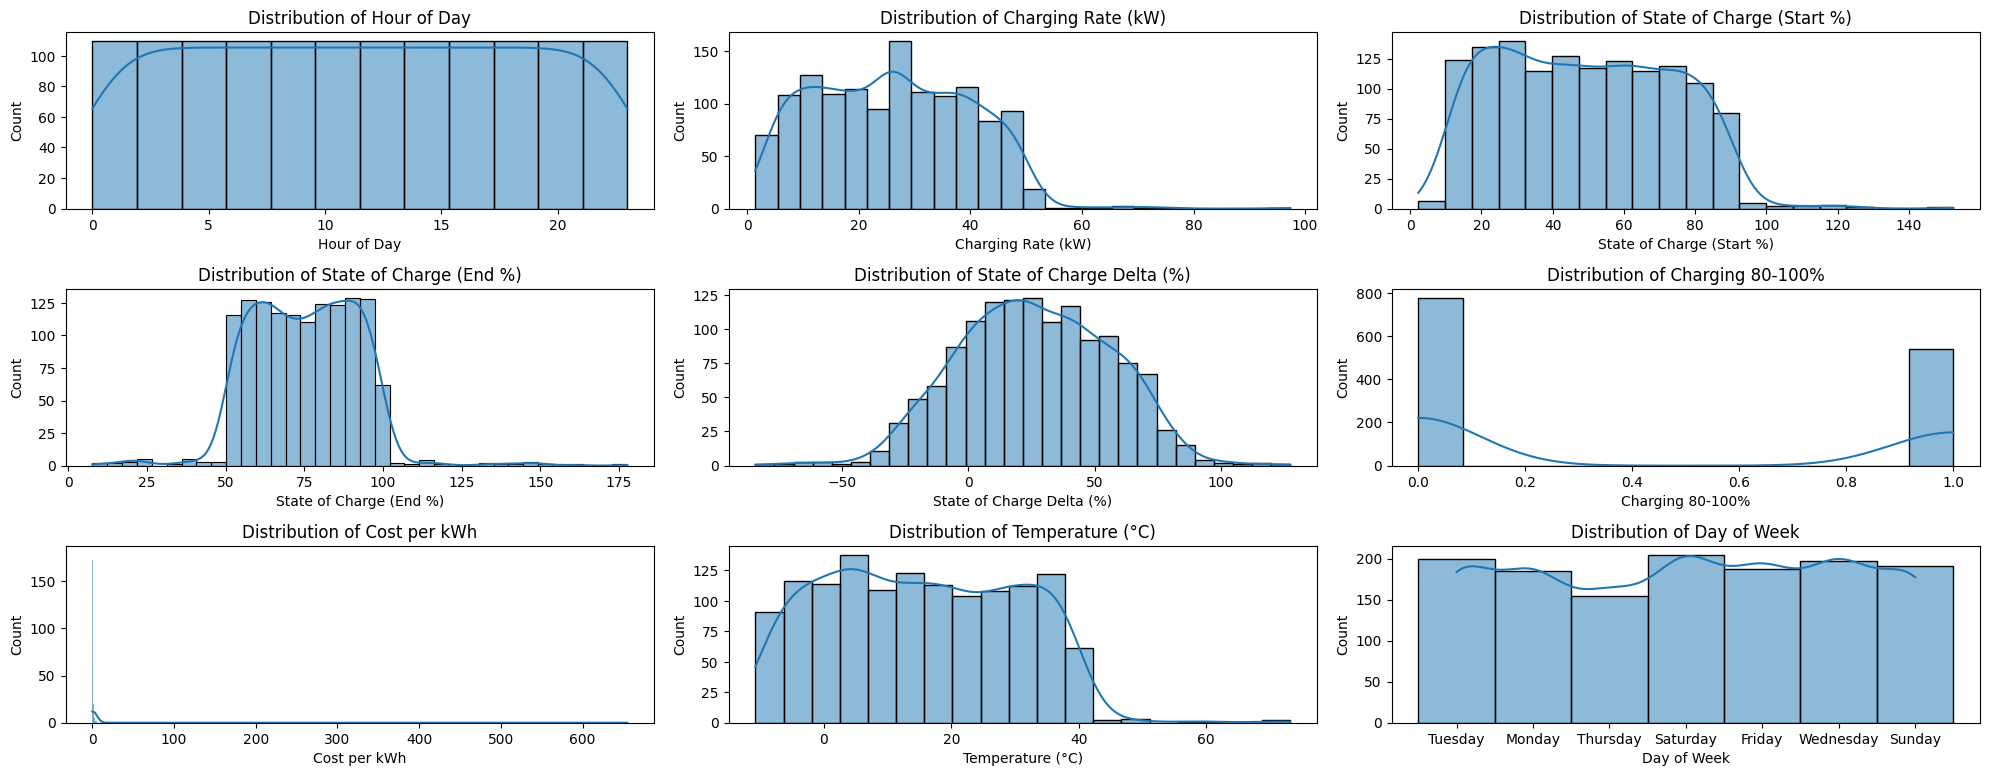

count
Charging Efficiency (kWh/hour)       
102.665033                          1
22.349169                           1
8.231458                            1
20.029157                           1
76.957882                           1
...                               ...
19.217528                           1
2.282839                            1
25.434369                           1
16.016992                           1
17.014989                           1

[1320 rows x 1 columns]

In [21]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Plot distribution of a single feature
for i, feature in enumerate(['Hour of Day', 'Charging Rate (kW)', 'State of Charge (Start %)',  'State of Charge (End %)',
                             'State of Charge Delta (%)', 'Charging 80-100%', 'Cost per kWh', 'Temperature (°C)', 'Day of Week']):
    plt.subplot(4, 3, i+1)  # Create a subplot for each feature
    sns.histplot(data[feature], kde=True)  # KDE plot overlays the histogram
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# Plot the distribution of the target variable
y1 = data['Charging Efficiency (kWh/hour)']
pd.DataFrame(y1.value_counts())

### Data Correlation ###

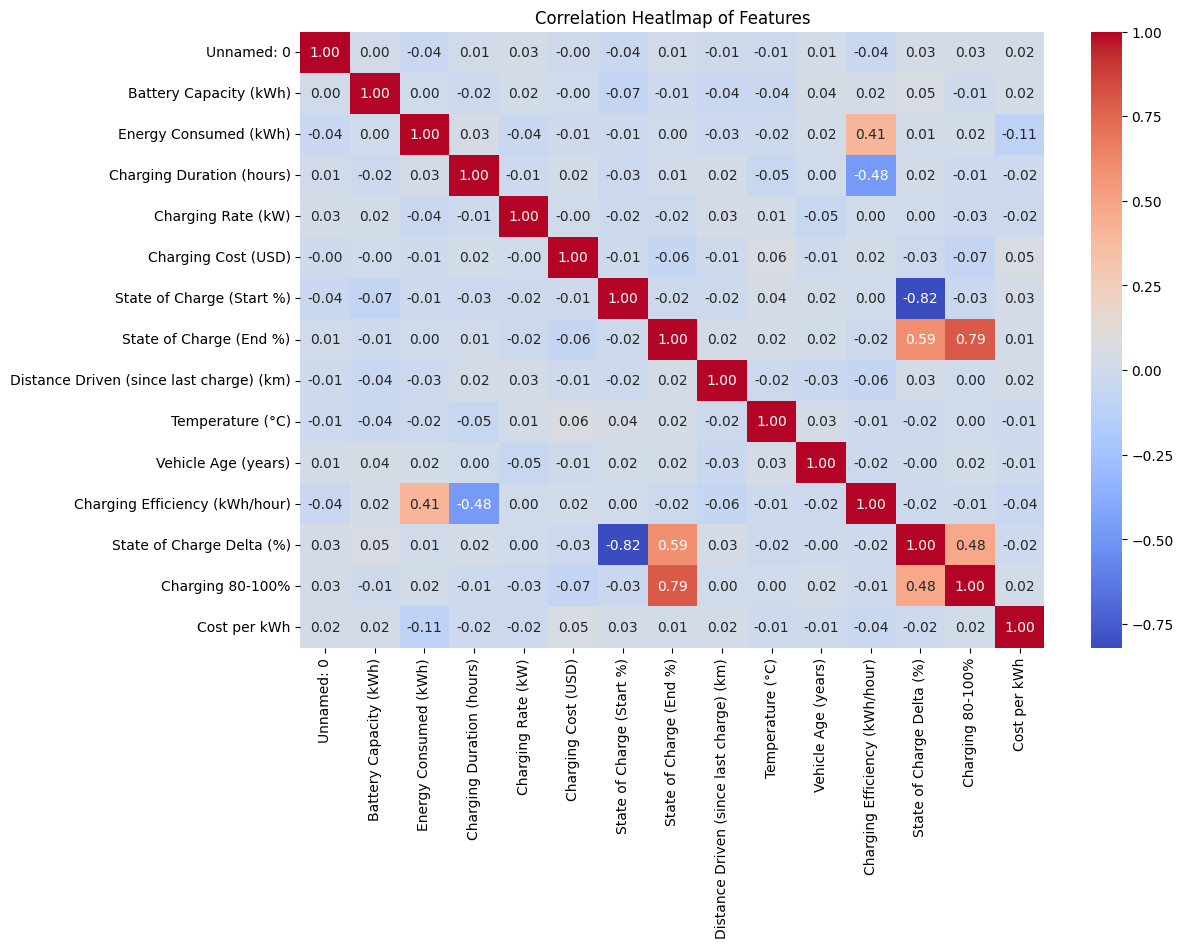

In [23]:
# Plot the correltion heatmap
# Select only numeric columns for correlation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatlmap of Features")
plt.show()

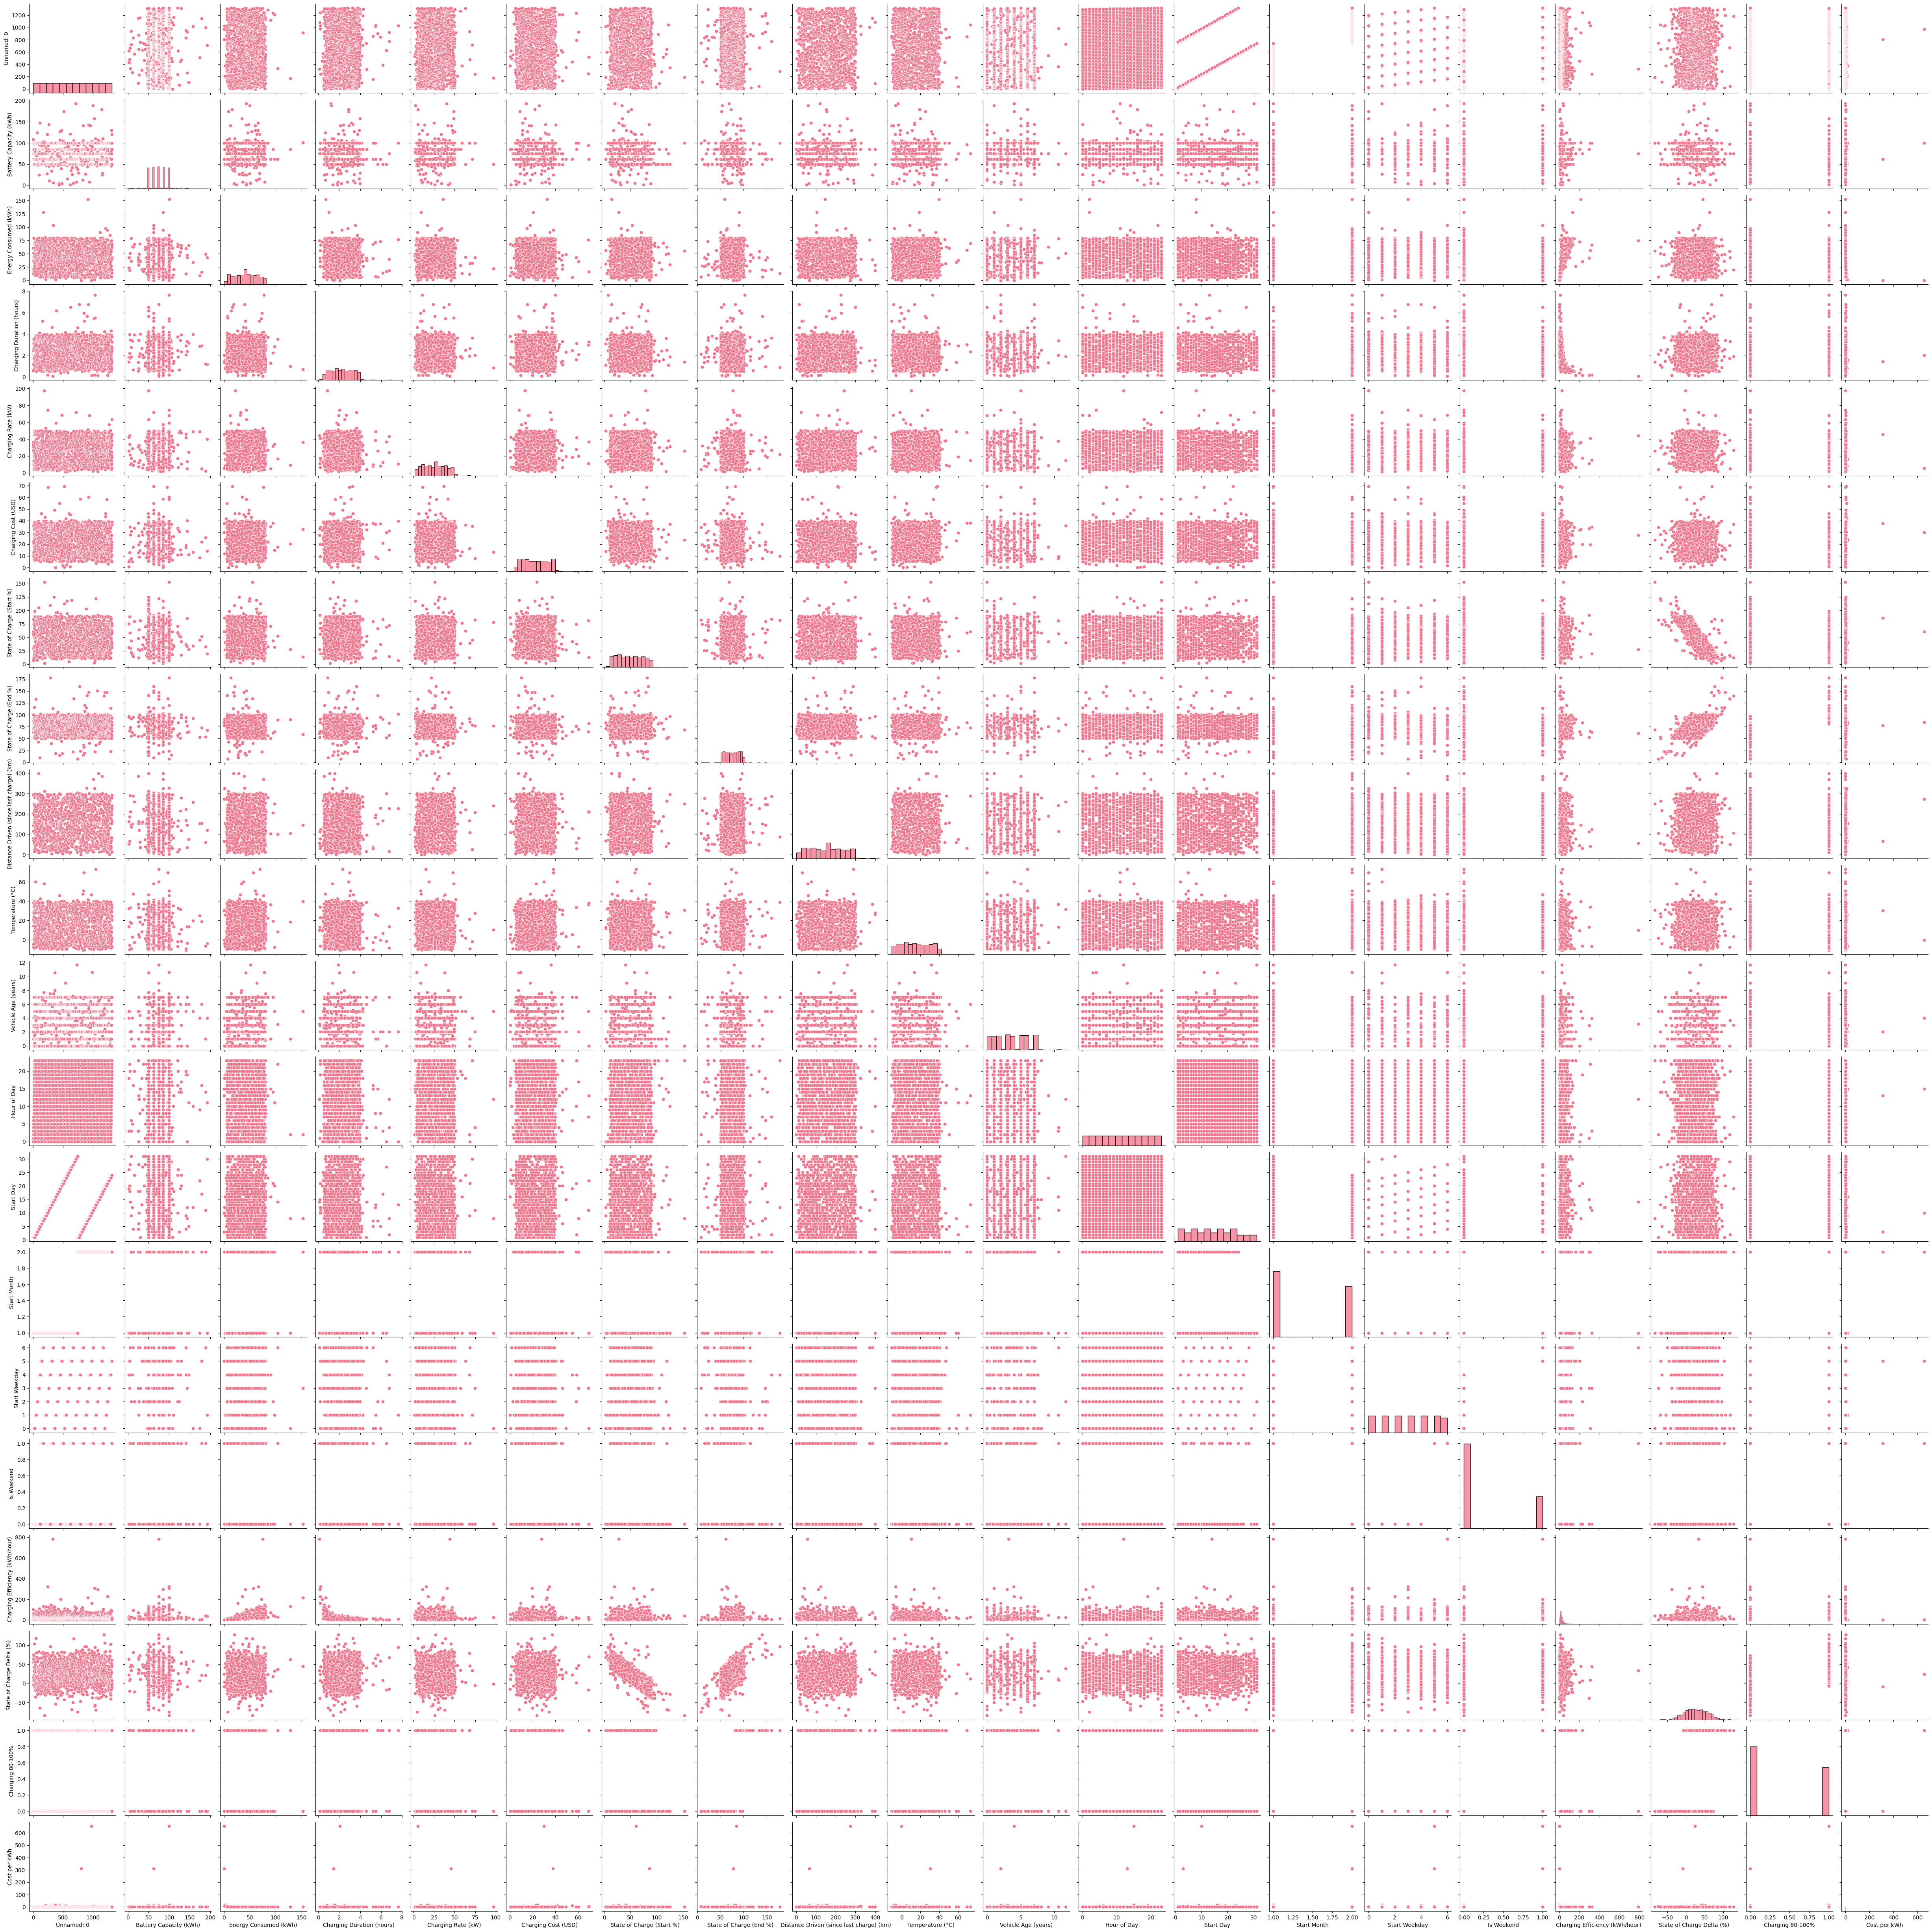

<Figure size 5000x4000 with 0 Axes>

In [26]:
sns.set_palette('husl')
%matplotlib inline
correlation = sns.pairplot(data, diag_kind='hist')
plt.figure(figsize=(50, 40))
plt.show()

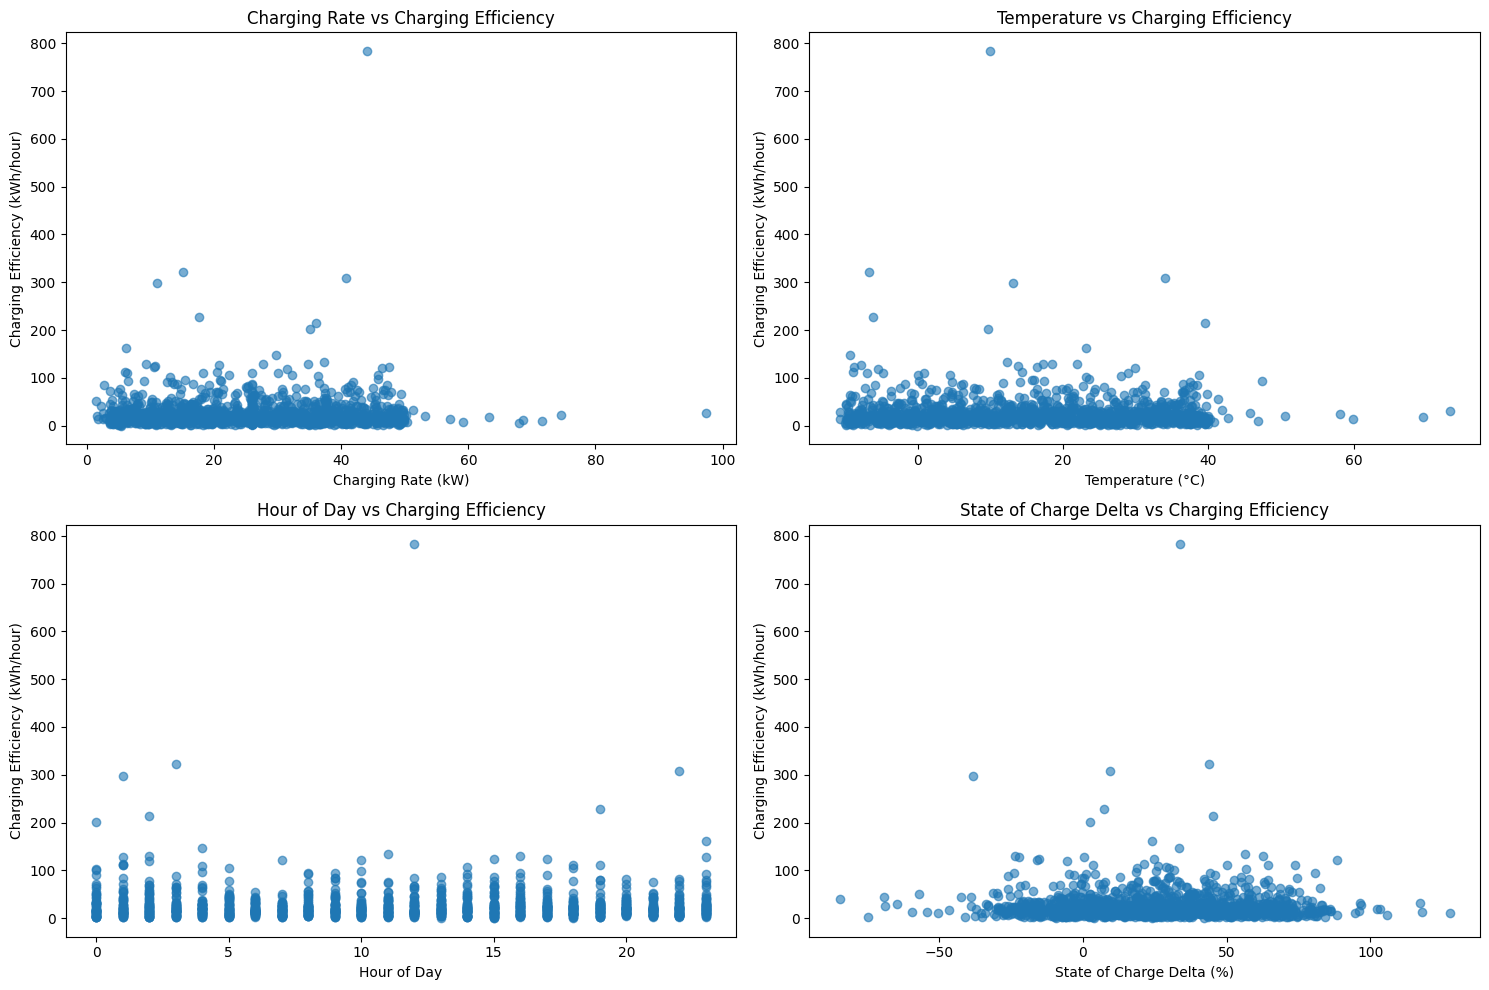

In [25]:
# Plot relationships between Charging Efficiency, State of Charge Delta, Hour of Day, Temperature, and Charging Rate
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Charging Efficiency vs. Charging Rate (kW)
axs[0, 0].scatter(data['Charging Rate (kW)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 0].set_xlabel('Charging Rate (kW)')
axs[0, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 0].set_title('Charging Rate vs Charging Efficiency')

# Plot 2: Charging Efficiency vs. Temperature (°C)
axs[0, 1].scatter(data['Temperature (°C)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 1].set_xlabel('Temperature (°C)')
axs[0, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 1].set_title('Temperature vs Charging Efficiency')

# Plot 3: Charging Efficiency vs. Hour of Day
axs[1, 0].scatter(data['Hour of Day'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 0].set_xlabel('Hour of Day')
axs[1, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 0].set_title('Hour of Day vs Charging Efficiency')

# Plot 4: Charging Efficiency vs. State of Charge Delta (%)
axs[1, 1].scatter(data['State of Charge Delta (%)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 1].set_xlabel('State of Charge Delta (%)')
axs[1, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 1].set_title('State of Charge Delta vs Charging Efficiency')

plt.tight_layout()
plt.show()

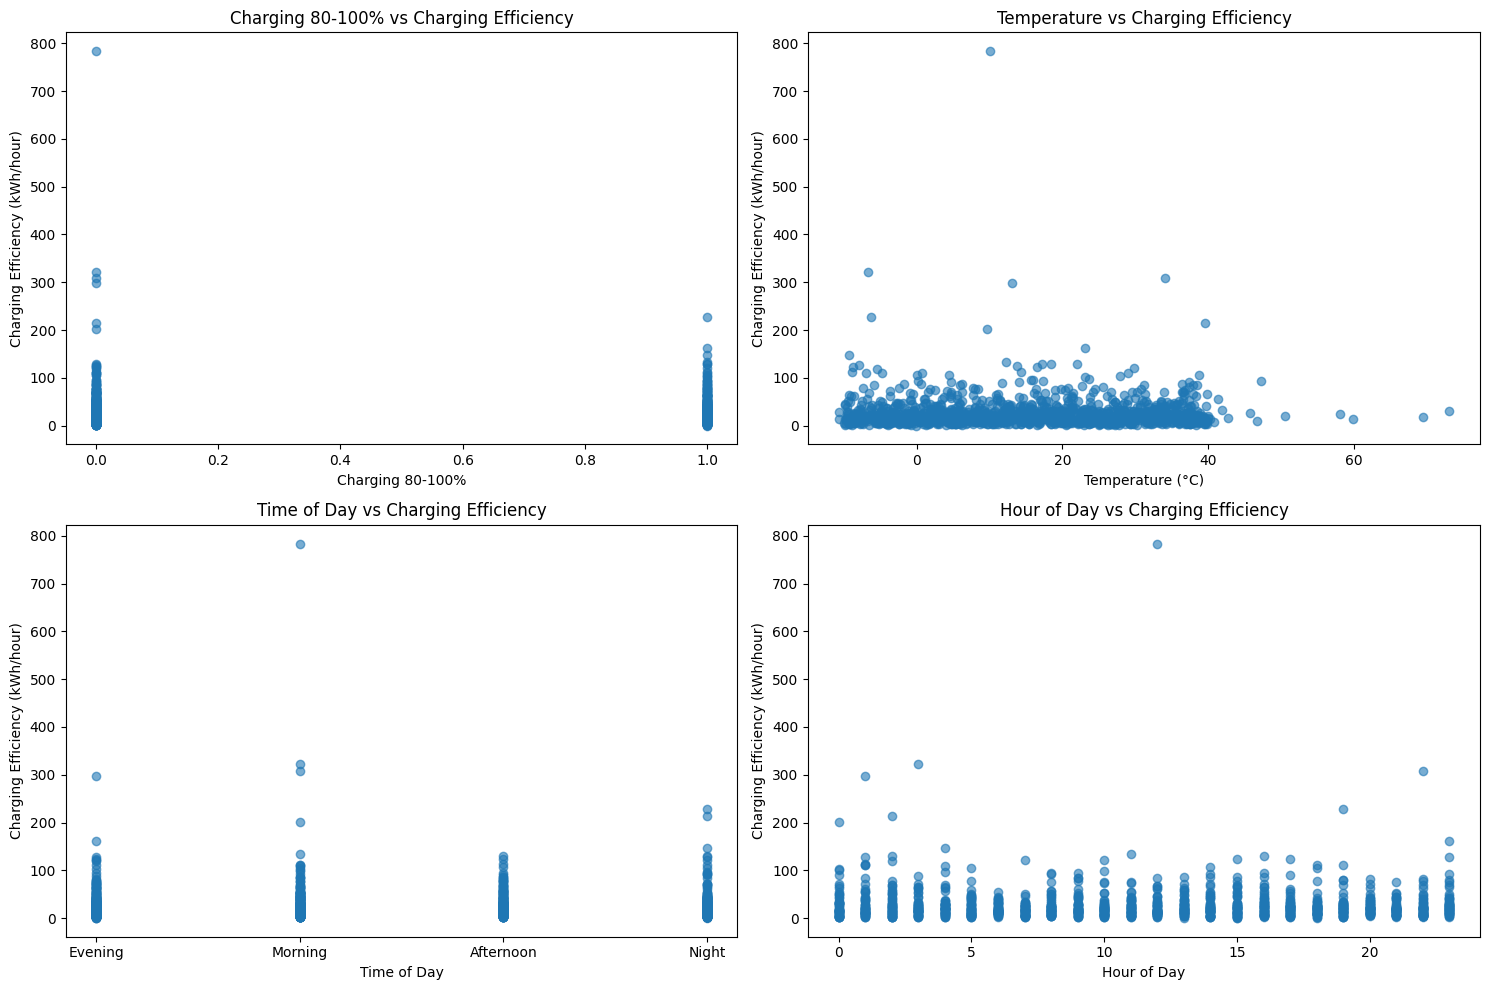

In [27]:
# Charging
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Charging Efficiency vs. Charging Rate (kW)
axs[0, 0].scatter(data['Charging 80-100%'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 0].set_xlabel('Charging 80-100%')
axs[0, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 0].set_title('Charging 80-100% vs Charging Efficiency')

# Plot 2: Charging Efficiency vs. Temperature (°C)
axs[0, 1].scatter(data['Temperature (°C)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 1].set_xlabel('Temperature (°C)')
axs[0, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 1].set_title('Temperature vs Charging Efficiency')

# Plot 3: Charging Efficiency vs. Hour of Day
axs[1, 0].scatter(data['Time of Day'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 0].set_xlabel('Time of Day')
axs[1, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 0].set_title('Time of Day vs Charging Efficiency')

# Plot 4: Charging Efficiency vs. State of Charge Delta (%)
axs[1, 1].scatter(data['Hour of Day'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 1].set_title('Hour of Day vs Charging Efficiency')

plt.tight_layout()
plt.show()

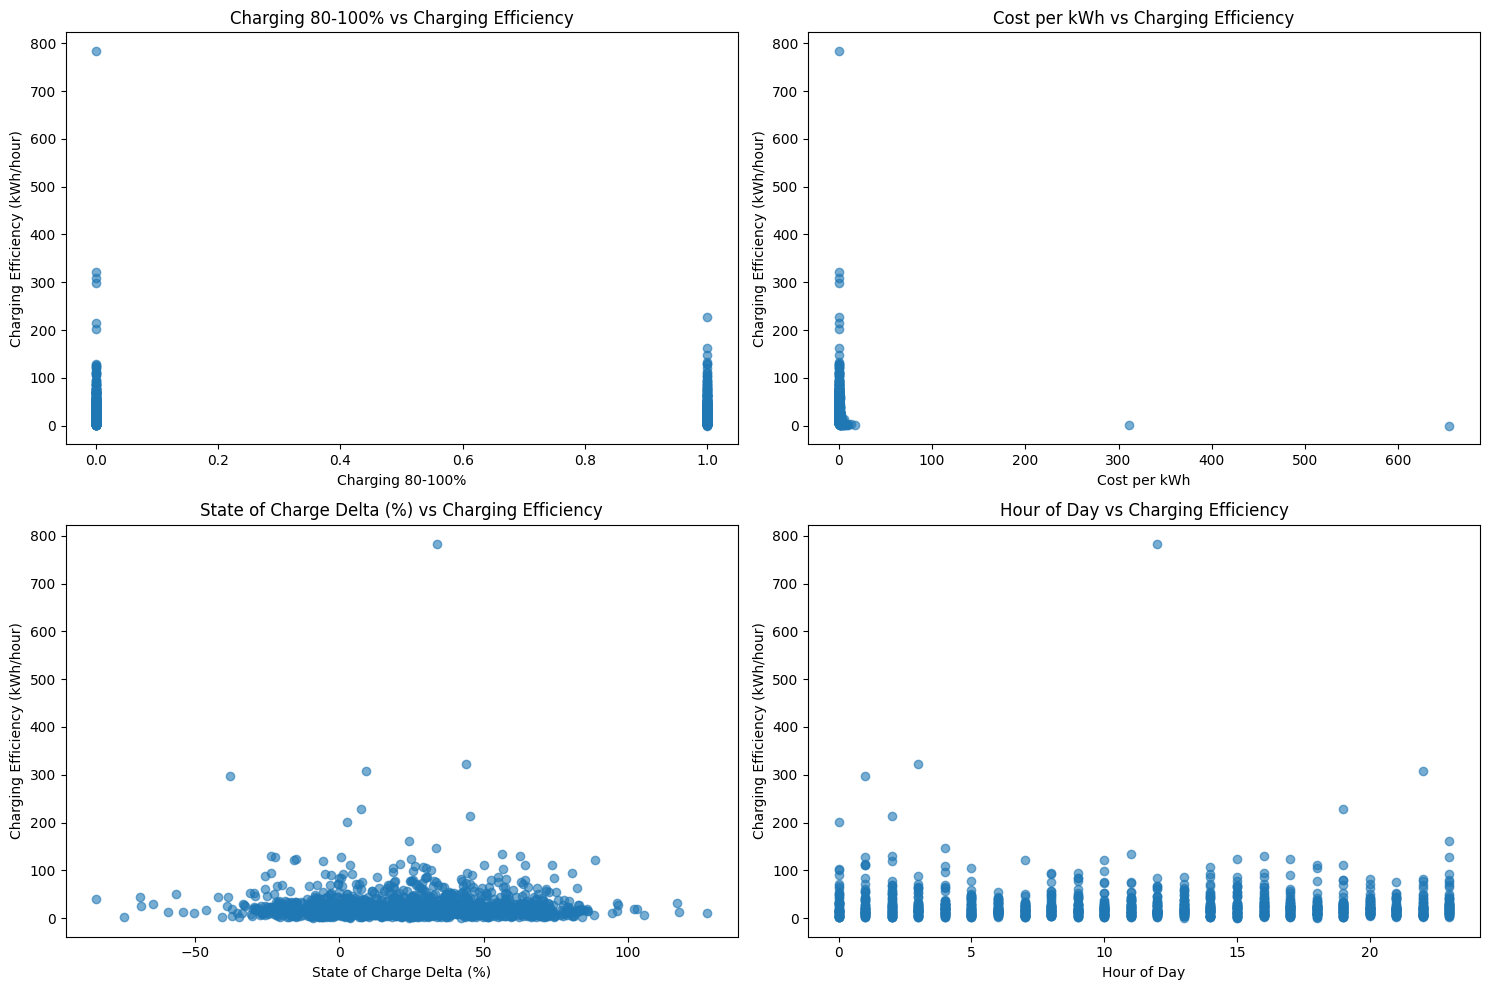

In [29]:
# Charging
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Charging Efficiency vs. Charging 80-100%
axs[0, 0].scatter(data['Charging 80-100%'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 0].set_xlabel('Charging 80-100%')
axs[0, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 0].set_title('Charging 80-100% vs Charging Efficiency')

# Plot 2: Charging Efficiency vs. Cost per kWh
axs[0, 1].scatter(data['Cost per kWh'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 1].set_xlabel('Cost per kWh')
axs[0, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 1].set_title('Cost per kWh vs Charging Efficiency')

# Plot 3: Charging Efficiency vs. State of Charge Delta (%)
axs[1, 0].scatter(data['State of Charge Delta (%)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 0].set_xlabel('State of Charge Delta (%)')
axs[1, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 0].set_title('State of Charge Delta (%) vs Charging Efficiency')

# Plot 4: Charging Efficiency vs. Hour of Day
axs[1, 1].scatter(data['Hour of Day'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 1].set_title('Hour of Day vs Charging Efficiency')

plt.tight_layout()
plt.show()

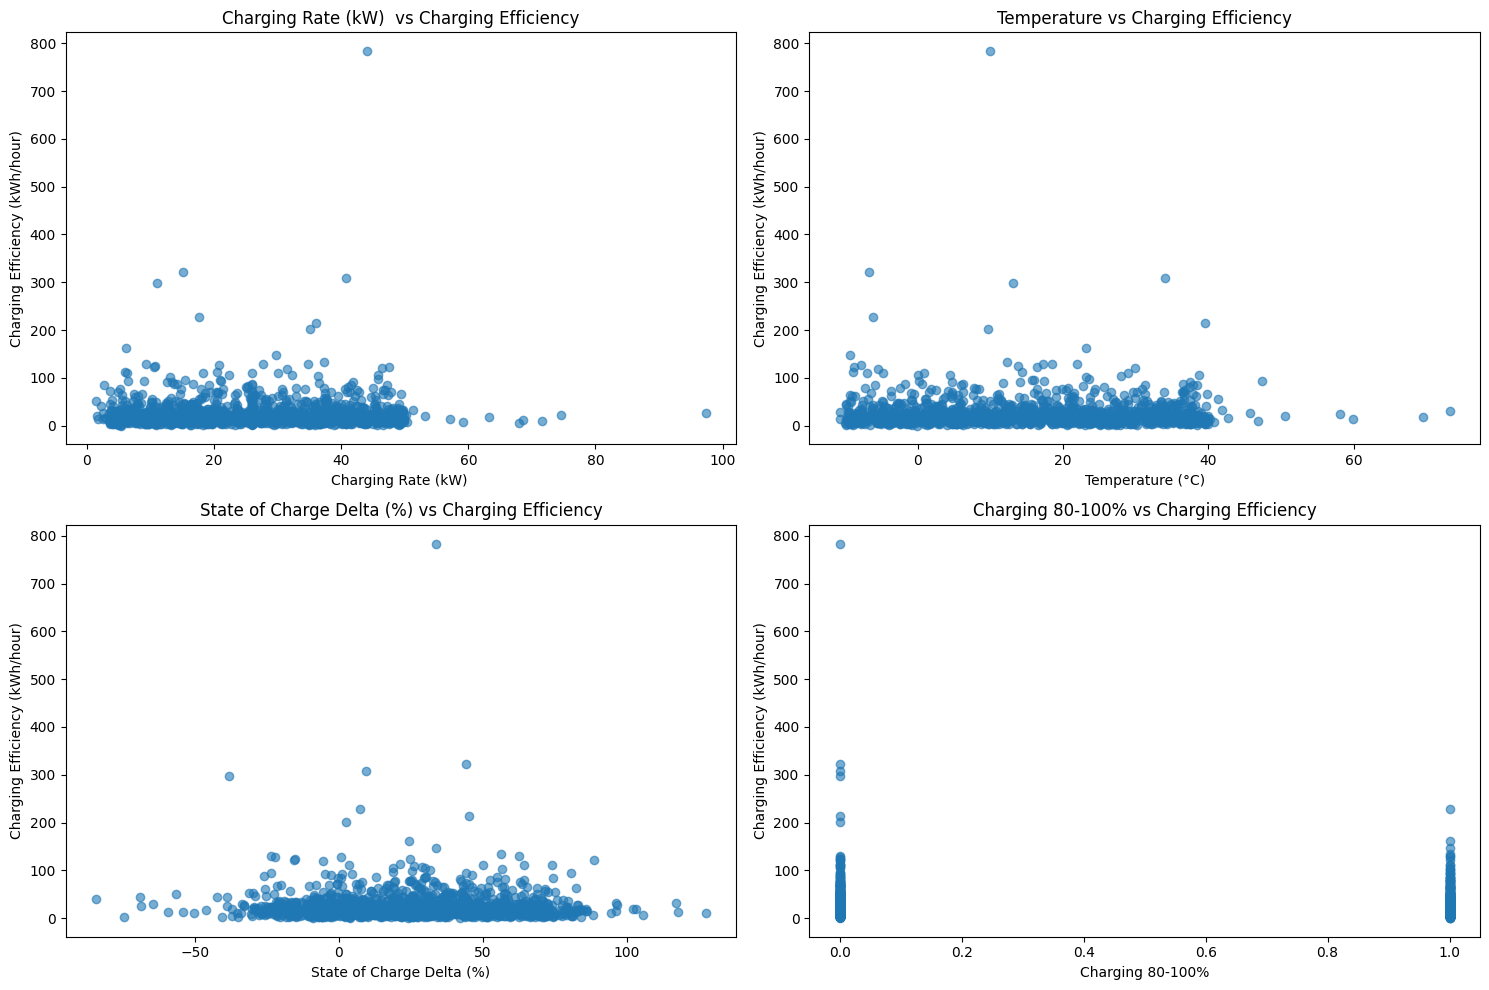

In [35]:
# Charging
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Charging Efficiency vs. Charging Rate (kW)
axs[0, 0].scatter(data['Charging Rate (kW)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 0].set_xlabel('Charging Rate (kW) ')
axs[0, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 0].set_title('Charging Rate (kW)  vs Charging Efficiency')

# Plot 2: Charging Efficiency vs. Temperature (°C)
axs[0, 1].scatter(data['Temperature (°C)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[0, 1].set_xlabel('Temperature (°C)')
axs[0, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 1].set_title('Temperature vs Charging Efficiency')

# Plot 3: Charging Efficiency vs. Hour of Day
axs[1, 0].scatter(data['State of Charge Delta (%)'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 0].set_xlabel('State of Charge Delta (%)')
axs[1, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 0].set_title('State of Charge Delta (%) vs Charging Efficiency')

# Plot 4: Charging Efficiency vs. Charging 80-100%
axs[1, 1].scatter(data['Charging 80-100%'], data['Charging Efficiency (kWh/hour)'], alpha=0.6, color='#1f77b4')
axs[1, 1].set_xlabel('Charging 80-100%')
axs[1, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 1].set_title('Charging 80-100% vs Charging Efficiency')

plt.tight_layout()
plt.show()

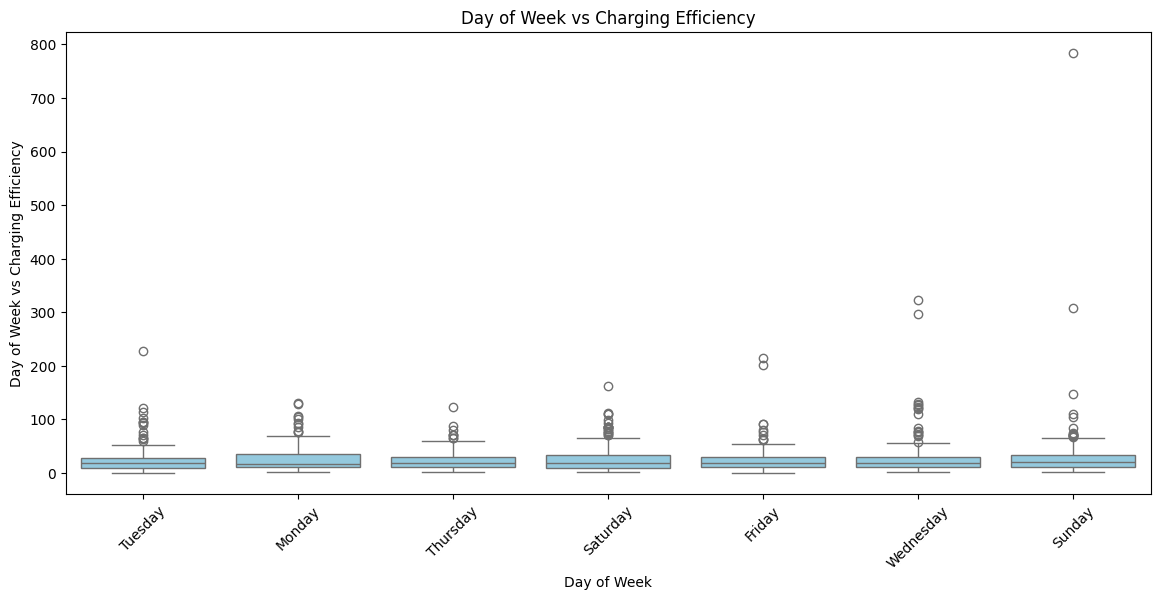

In [34]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Day of Week', y='Charging Efficiency (kWh/hour)', data=data, color="#87CEEB")
plt.title('Day of Week vs Charging Efficiency')
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Day of Week vs Charging Efficiency')
plt.show()

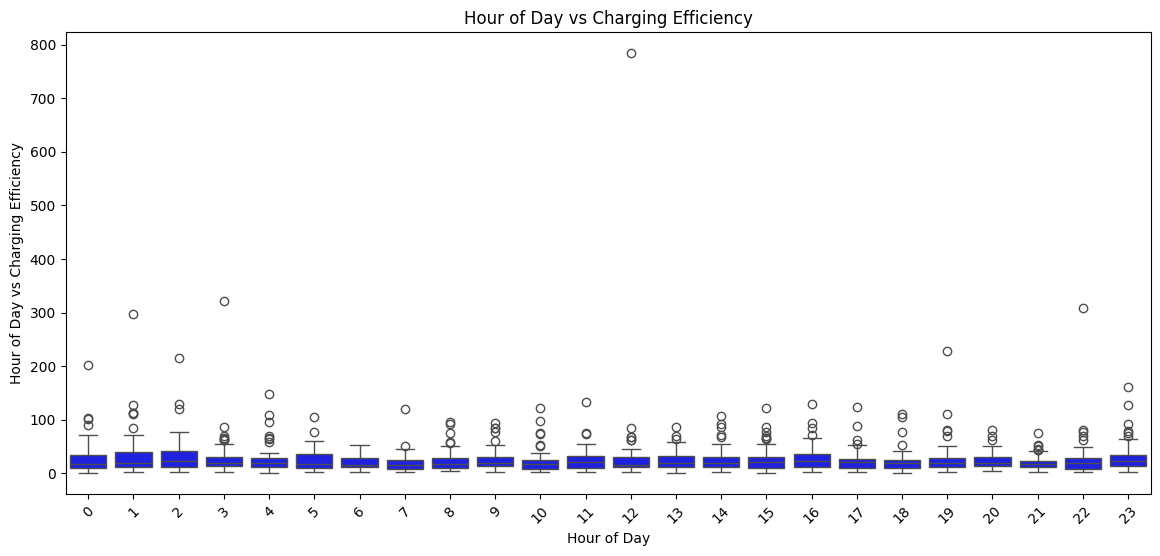

In [36]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Hour of Day', y='Charging Efficiency (kWh/hour)', data=data, color='blue')
plt.title('Hour of Day vs Charging Efficiency')
plt.xticks(rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Hour of Day vs Charging Efficiency')
plt.show()

In [38]:
# Create temperature bands
def categorize_temperature(temp):
    if temp <= 0:
        return 'Cold'
    elif temp <= 20:
        return 'Moderate'
    else:
        return 'Hot'

data['Temperature Band'] = data['Temperature (°C)'].apply(categorize_temperature)

In [40]:
categorical_features = ['Vehicle Model', 'Charger Type', 'User Type', 'Time of Day', 'Temperature Band']

# Use get_dummies for one-hot encoding
data = pd.get_dummies(data, columns=categorical_features)

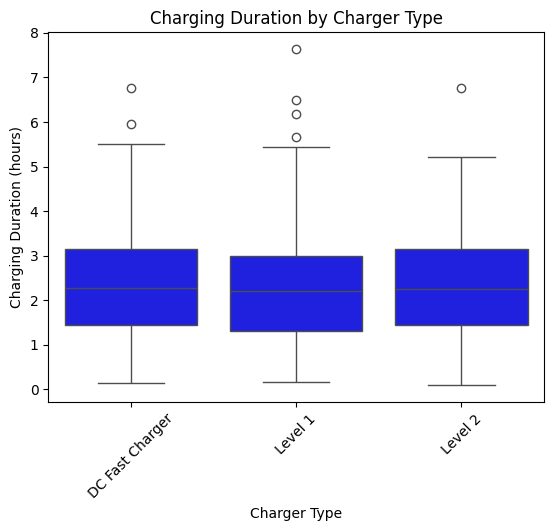

In [42]:
# Temporarily create a new 'Charger Type' column based on one-hot encoded columns
data['Charger Type'] = data[['Charger Type_DC Fast Charger', 'Charger Type_Level 1', 'Charger Type_Level 2']].idxmax(axis=1)

# Remove the prefix from the column values for cleaner plotting
data['Charger Type'] = data['Charger Type'].str.replace('Charger Type_', '')

# Now plot the boxplot for Charging Duration by Charger Type
sns.boxplot(x='Charger Type', y='Charging Duration (hours)', data=data, color='blue')
plt.title('Charging Duration by Charger Type')
plt.xticks(rotation=45)
plt.show()

### Features Importance ###

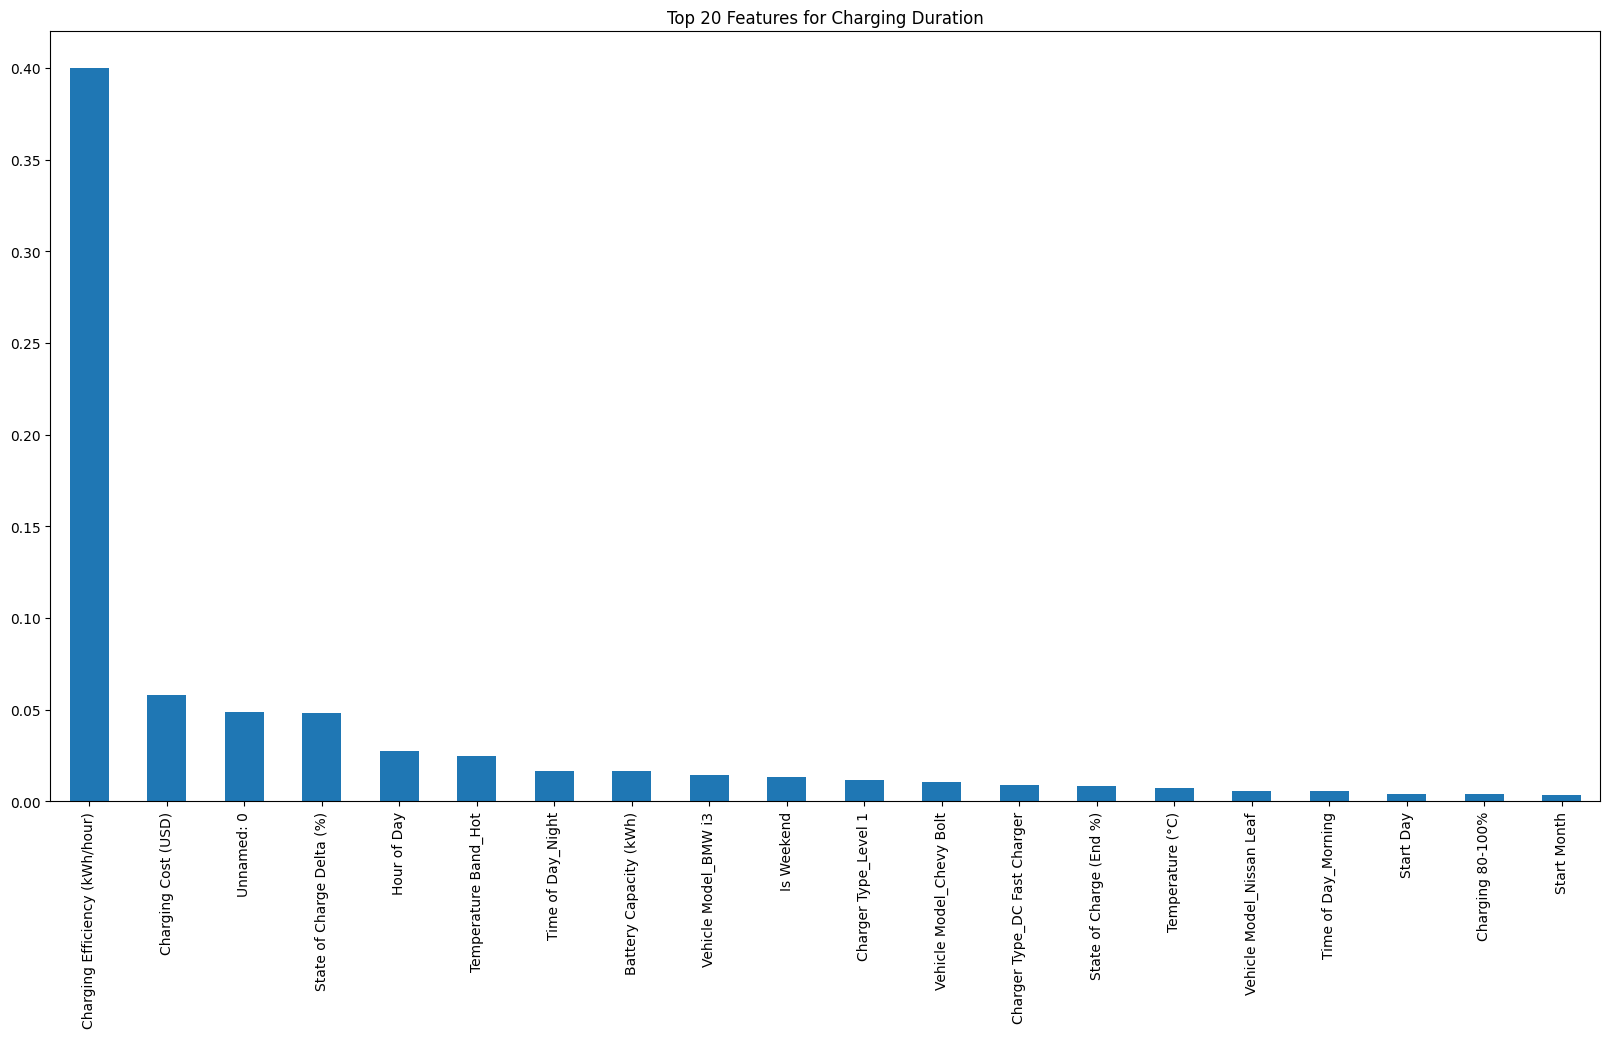

In [44]:
# Drop the temporary 'Charger Type' column to revert the DataFrame to its original state
data = data.drop(columns=['Charger Type'])

# Features to scale
features_to_scale = ['Battery Capacity (kWh)', 'Charging Duration (hours)', 'Energy Consumed (kWh)',
                     'Charging Rate (kW)', 'Charging Cost (USD)', 'State of Charge Delta (%)', 
                     'State of Charge (Start %)', 'State of Charge (End %)', 
                     'Distance Driven (since last charge) (km)', 'Temperature (°C)', 
                     'Vehicle Age (years)', 'Charging Efficiency (kWh/hour)', 'Cost per kWh']

scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Define the target variable and features
X = data.drop(columns=['Charging Duration (hours)', 'User ID', 'Charging Station ID', 'Day of Week',
                       'Charging Station Location', 'Charging Start Time', 'Charging End Time'])
y = data['Charging Duration (hours)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an imputer to fill NaN values with the mean (or you can use other strategies)
imputer = SimpleImputer(strategy='mean')

# Impute missing values in X_train
X_train_imputed = imputer.fit_transform(X_train)

# Encode categorical variables in X_train
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Apply LabelEncoder to these columns
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

# Now calculate mutual information for 'Charging Duration'
mi_scores_duration = mutual_info_regression(X_train_imputed, y_train)
mi_scores_duration = pd.Series(mi_scores_duration, name='MI Scores', index=X_train.columns)
mi_scores_duration = mi_scores_duration.sort_values(ascending=False)

# Plot MI scores
mi_scores_duration[0:20].plot.bar(figsize=(20, 10), color='#1f77b4')
plt.title('Top 20 Features for Charging Duration')
plt.show()

### Defining fuzzy membership functions ###

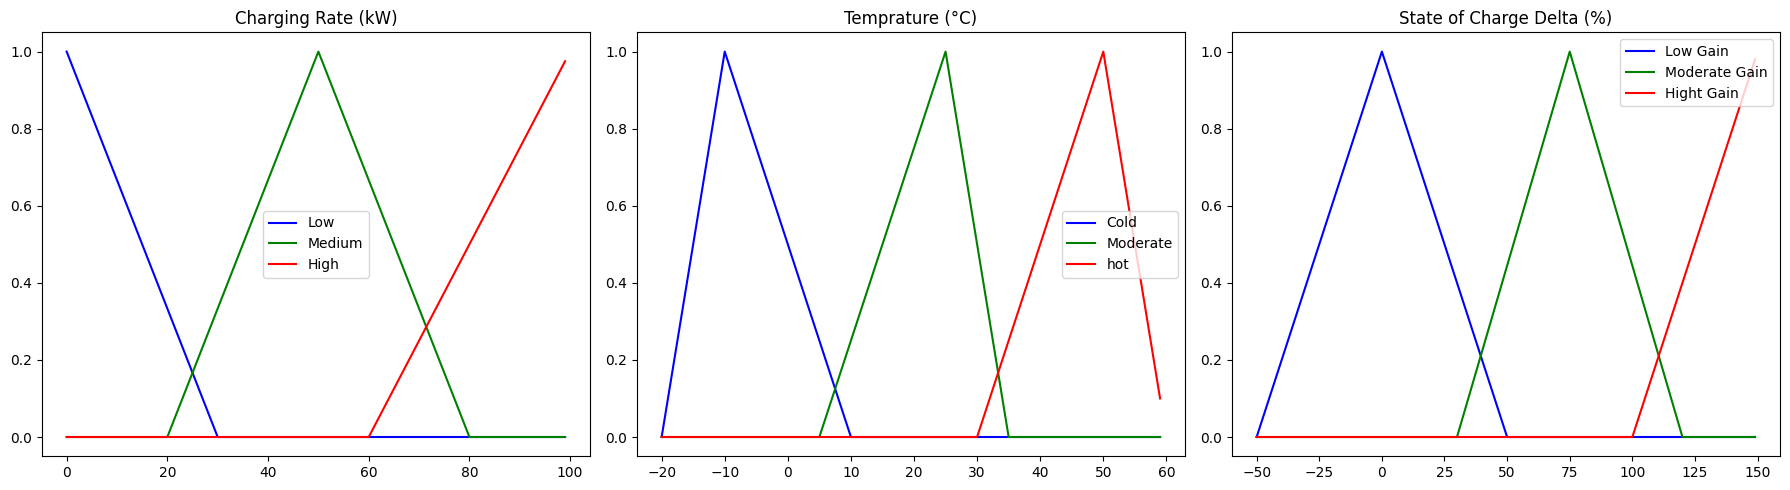

In [34]:
# Define the range of values for each variable based on data
x_charging_rate = np.arange(0, 100, 1) # Charging Rate from 0 to 100 kW
x_temperature = np.arange(-20, 60, 1) # Temperature from -20°C to 80°C
x_soc_delta = np.arange(-50, 150, 1) # State of Charge Delta from 0% to 150%
x_charging_efficiency = np.arange(0, 150, 1)     # Charging Efficiency from 0% to 150%

# 1. Charging Rate Membership Functions (Low, Medium, Hight)
charging_rate_low = fuzz.trimf(x_charging_rate, [0,0,30])
charging_rate_medium = fuzz.trimf(x_charging_rate, [20,50,80])
charging_rate_high = fuzz.trimf(x_charging_rate, [60, 100, 100])

# 2. Temperature Membership Functions (Cold, Optimal, Hot)
temperature_cold = fuzz.trimf(x_temperature, [-20, -10, 10])
temperature_moderate = fuzz.trimf(x_temperature, [5, 25, 35])
temperature_hot = fuzz.trimf(x_temperature, [30, 50, 60])

# 3. State of Charge Delta Membership Functions (Low Gain, Moderate Gain, High Gain)
soc_delta_low = fuzz.trimf(x_soc_delta, [-50, 0, 50])
soc_delta_moderate = fuzz.trimf(x_soc_delta, [30, 75, 120])
soc_delta_hight = fuzz.trimf(x_soc_delta, [100, 150, 150])

# 4 Charging efficiency Membership Functions
charging_efficiency_low = fuzz.trimf(x_charging_efficiency, [0, 0, 40])
charging_efficiency_medium = fuzz.trimf(x_charging_efficiency, [20, 50, 80])
charging_efficiency_high = fuzz.trimf(x_charging_efficiency, [60, 150, 150])

# Plot Membership Functions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Charging Rate
axs[0].plot(x_charging_rate, charging_rate_low, 'b', label='Low')
axs[0].plot(x_charging_rate, charging_rate_medium, 'g', label='Medium')
axs[0].plot(x_charging_rate, charging_rate_high, 'r', label='High')
axs[0].set_title('Charging Rate (kW)')
axs[0].legend()

# Temperature
axs[1].plot(x_temperature, temperature_cold, 'b', label='Cold')
axs[1].plot(x_temperature, temperature_moderate, 'g', label='Moderate')
axs[1].plot(x_temperature, temperature_hot, 'r', label='hot')
axs[1].set_title('Temprature (°C)')
axs[1].legend()

# State of Charge Delta
axs[2].plot(x_soc_delta, soc_delta_low, 'b', label='Low Gain')
axs[2].plot(x_soc_delta, soc_delta_moderate, 'g', label='Moderate Gain')
axs[2].plot(x_soc_delta, soc_delta_hight, 'r', label='Hight Gain')
axs[2].set_title('State of Charge Delta (%)')
axs[2].legend()

plt.tight_layout()
plt.show()

### ANFIS Modeling ###

Enter the current charging rate (kW): 27
Enter the current outdoor temperature in Celsius (°C): 20
How many percentage of battery you need to charge: 30


Epoch [100/1000], Loss: 1129.8118
Epoch [200/1000], Loss: 270.1653
Epoch [300/1000], Loss: 27.2472
Epoch [400/1000], Loss: 17.6995
Epoch [500/1000], Loss: 13.2723
Epoch [600/1000], Loss: 9.5525
Epoch [700/1000], Loss: 6.5693
Epoch [800/1000], Loss: 4.2926
Epoch [900/1000], Loss: 2.6492
Epoch [1000/1000], Loss: 1.5359
Predicted Charging Efficiency: 64.82%
Charging Efficiency Category: Medium


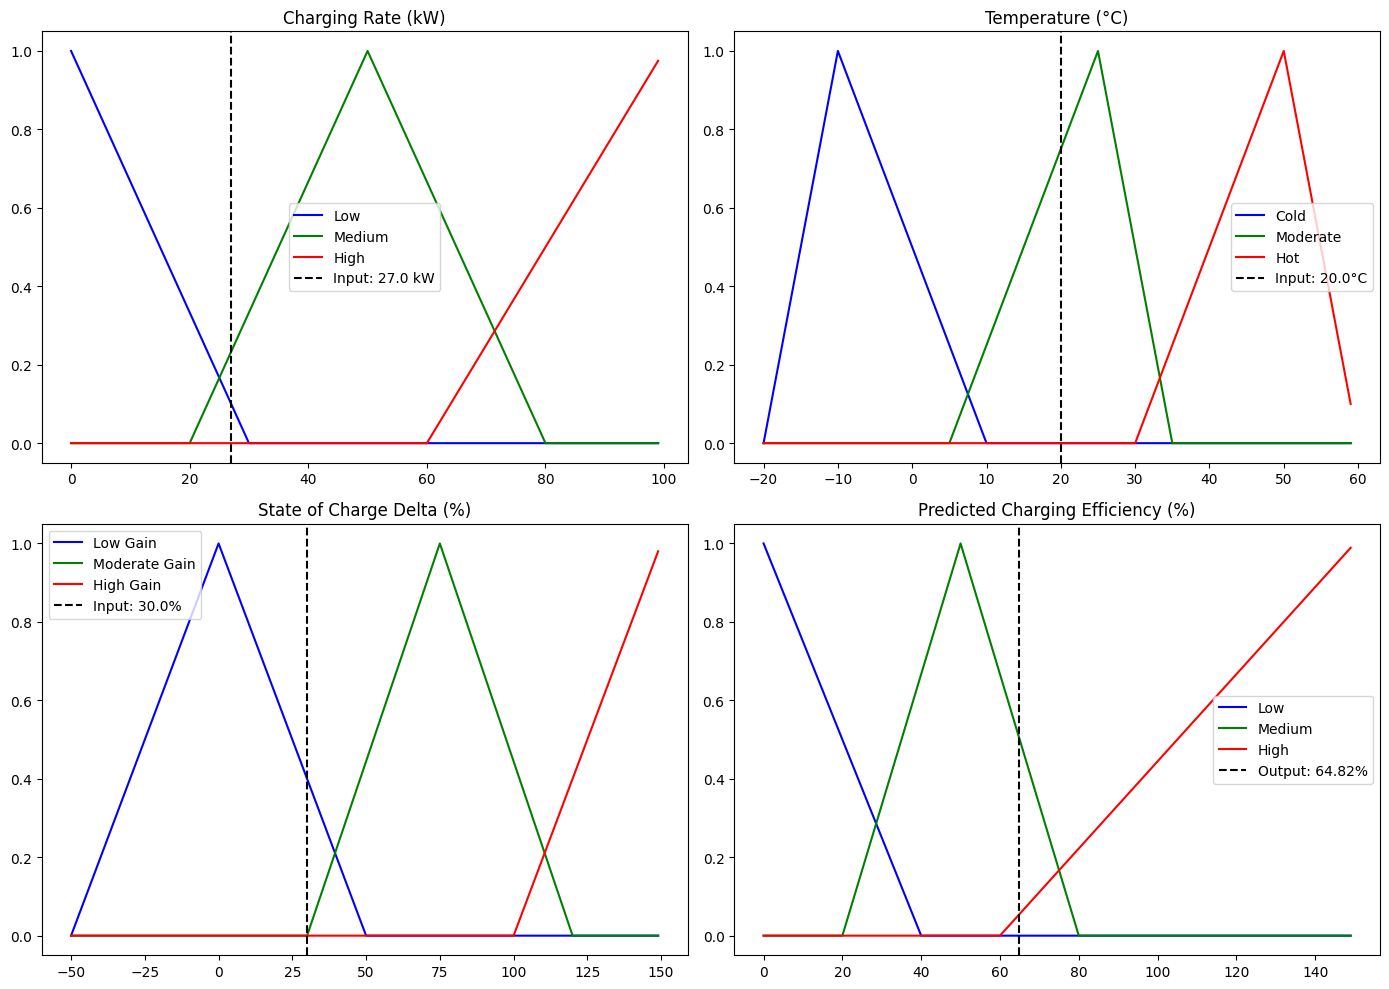

In [38]:
# Define Gaussian Membership Function as a PyTorch layer
class GaussianMembFunc(nn.Module):
    def __init__(self, mean, std_dev):
        super(GaussianMembFunc, self).__init__()
        self.mean = nn.Parameter(torch.tensor(mean, dtype=torch.float32))
        self.std_dev = nn.Parameter(torch.tensor(std_dev, dtype=torch.float32))

    def forward(self, x):
        return torch.exp(-0.5 * ((x - self.mean) / self.std_dev) **2)

# Define the ANFIS model
class ANFISModel(nn.Module):
    def __init__(self):
        # Layer 1: Define ANFIS model to take the crisp inputs
        super(ANFISModel, self).__init__()
        
        # Layer 2: Input Membership functions for each input
        self.charging_rate_low = GaussianMembFunc(mean=15, std_dev=10)
        self.charging_rate_medium = GaussianMembFunc(mean=50, std_dev=15)
        self.charging_rate_high = GaussianMembFunc(mean=85, std_dev=10)

        self.temperature_cold = GaussianMembFunc(mean=0, std_dev=15)
        self.temperature_moderate = GaussianMembFunc(mean=20, std_dev=10)
        self.temperature_hot = GaussianMembFunc(mean=35, std_dev=10)

        self.soc_delta_low = GaussianMembFunc(mean=10, std_dev=10)
        self.soc_delta_moderate = GaussianMembFunc(mean=50, std_dev=15)
        self.soc_delta_high = GaussianMembFunc(mean=90, std_dev=10)

        # Rule layer weights (initialized closer to 1 for reasonable starting influence)
        self.rule_weights = nn.Parameter(torch.ones(27, dtype=torch.float32))

    def forward(self, x):
        # Layer 3: Input/Apply membership functions
        cr_low = self.charging_rate_low(x[:, 0])
        cr_medium = self.charging_rate_medium(x[:, 0])
        cr_high = self.charging_rate_high(x[:, 0])

        temp_cold = self.temperature_cold(x[:, 1])
        temp_moderate = self.temperature_moderate(x[:, 1])
        temp_hot = self.temperature_hot(x[:, 1])

        soc_delta_low = self.soc_delta_low(x[:, 2])
        soc_delta_moderate = self.soc_delta_moderate(x[:, 2])
        soc_delta_high = self.soc_delta_high(x[:, 2])

        # Layer 4: Combine membership function outputs to form Fuzzy Rules
        rule_strengths = torch.stack([
            cr_low * temp_cold * soc_delta_low,
            cr_low * temp_cold * soc_delta_moderate,
            cr_low * temp_cold * soc_delta_high,
            cr_low * temp_moderate * soc_delta_low,
            cr_low * temp_moderate * soc_delta_moderate,
            cr_low * temp_moderate * soc_delta_high,
            cr_low * temp_hot * soc_delta_low,
            cr_low * temp_hot * soc_delta_moderate,
            cr_low * temp_hot * soc_delta_high,
            cr_medium * temp_cold * soc_delta_low,
            cr_medium * temp_cold * soc_delta_moderate,
            cr_medium * temp_cold * soc_delta_high,
            cr_medium * temp_moderate * soc_delta_low,
            cr_medium * temp_moderate * soc_delta_moderate,
            cr_medium * temp_moderate * soc_delta_high,
            cr_medium * temp_hot * soc_delta_low,
            cr_medium * temp_hot * soc_delta_moderate,
            cr_medium * temp_hot * soc_delta_high,
            cr_high * temp_cold * soc_delta_low,
            cr_high * temp_cold * soc_delta_moderate,
            cr_high * temp_cold * soc_delta_high,
            cr_high * temp_moderate * soc_delta_low,
            cr_high * temp_moderate * soc_delta_moderate,
            cr_high * temp_moderate * soc_delta_high,
            cr_high * temp_hot * soc_delta_low,
            cr_high * temp_hot * soc_delta_moderate,
            cr_high * temp_hot * soc_delta_high
        ], dim=1)
        
        # Apply weights to rule strengths
        weighted_rules = rule_strengths * self.rule_weights
        
        # Layer 5: Output layer for defuzzification - sum weighted rule outputs
        output = weighted_rules.sum(dim=1) * 100  # Scale up output for reasonable efficiency values

        return output

# Cripsp inputs layer: Get user inputs for real time prediction
charging_rate_input = float(input('Enter the current charging rate (kW):'))
temperature_input = float(input('Enter the current outdoor temperature in Celsius (°C):'))
soc_delta_input = float(input('How many percentage of battery you need to charge:'))

# Flat the user input data to 1 dimention by using tensor before putting in the neural network
user_input = torch.tensor([[charging_rate_input, temperature_input, soc_delta_input]], dtype=torch.float32)

# Initialize the model and set up the optimizer
model = ANFISModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Load the dataset
df = pd.DataFrame(df)
features = df.drop(columns=['Charging Efficiency (kWh/hour)'])
target = df['Charging Efficiency (kWh/hour)']

# Training loop with dummy data 
X_train = torch.tensor(features.values, dtype=torch.float32)
y_train = torch.tensor(target.values, dtype=torch.float32).reshape(-1,1)

for epoch in range(1000):
    optimizer.zero_grad()
    #y_pred = model(X_train)
    y_pred = model(X_train).unsqueeze(1)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

# Defuzzification Layer: Predict charging efficiency with the trained model
defuzzified_output = model(user_input).item()  # Scale output back up

# Convert to charging efficiency category
if defuzzified_output < 40:
    category = "Low"
elif 40 <= defuzzified_output <= 80:
    category = "Medium"
else:
    category = "High"

print(f"Predicted Charging Efficiency: {defuzzified_output:.2f}%")
print(f"Charging Efficiency Category: {category}")

# Plot the membership functions
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Charging Rate MF
axs[0, 0].plot(x_charging_rate, charging_rate_low, 'b', label='Low')
axs[0, 0].plot(x_charging_rate, charging_rate_medium, 'g', label='Medium')
axs[0, 0].plot(x_charging_rate, charging_rate_high, 'r', label='High')
axs[0, 0].axvline(charging_rate_input, color='k', linestyle='--', label=f'Input: {charging_rate_input} kW')
axs[0, 0].set_title('Charging Rate (kW)')
axs[0, 0].legend()

# Plot Temperature MF
axs[0, 1].plot(x_temperature, temperature_cold, 'b', label='Cold')
axs[0, 1].plot(x_temperature, temperature_moderate, 'g', label='Moderate')
axs[0, 1].plot(x_temperature, temperature_hot, 'r', label='Hot')
axs[0, 1].axvline(temperature_input, color='k', linestyle='--', label=f'Input: {temperature_input}°C')
axs[0, 1].set_title('Temperature (°C)')
axs[0, 1].legend()

# Plot State of Charge Delta MF
axs[1, 0].plot(x_soc_delta, soc_delta_low, 'b', label='Low Gain')
axs[1, 0].plot(x_soc_delta, soc_delta_moderate, 'g', label='Moderate Gain')
axs[1, 0].plot(x_soc_delta, soc_delta_hight, 'r', label='High Gain')
axs[1, 0].axvline(soc_delta_input, color='k', linestyle='--', label=f'Input: {soc_delta_input}%')
axs[1, 0].set_title('State of Charge Delta (%)')
axs[1, 0].legend()

# Plot Charging Efficiency MF and show the defuzzified result
axs[1, 1].plot(x_charging_efficiency, charging_efficiency_low, 'b', label='Low')
axs[1, 1].plot(x_charging_efficiency, charging_efficiency_medium, 'g', label='Medium')
axs[1, 1].plot(x_charging_efficiency, charging_efficiency_high, 'r', label='High')
axs[1, 1].axvline(defuzzified_output, color='k', linestyle='--', label=f'Output: {defuzzified_output:.2f}%')
axs[1, 1].set_title('Predicted Charging Efficiency (%)')
axs[1, 1].legend()

plt.tight_layout()
plt.show()